### Time Series Forecasting with Prophet

Article: [An End-to-End Project on Time Series Analysis and Forecasting with Python](https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b)

Dataset: [Superstore Sales](https://community.tableau.com/docs/DOC-1236)

In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
import itertools
import pandas as pd
import numpy as np
from fbprophet import Prophet
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pylab import rcParams

#### Load data

In [3]:
df = pd.read_excel('./datasets/superstore.xls')

In [4]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [5]:
furniture = df.loc[df['Category'] == 'Furniture']
office = df.loc[df['Category'] == 'Office Supplies']

In [6]:
furniture.shape, office.shape

((2121, 21), (6026, 21))

#### Data preprocessing

Drop unnecessary columns.

In [7]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']

In [8]:
furniture.drop(cols, axis=1, inplace=True)
office.drop(cols, axis=1, inplace=True)

Sort and aggregate.

In [9]:
furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')

In [10]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()

Set `Order Date` as index.

In [11]:
furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')

Resample data on Month Start frequency.

In [12]:
y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()

Convert into pandas dataframe.

In [13]:
furniture = pd.DataFrame({'Order Date': y_furniture.index,
                         'Sales': y_furniture.values})
office = pd.DataFrame({'Order Date': y_office.index,
                      'Sales': y_office.values})

Merge `furniture` and `office` as `store`.

In [14]:
store = furniture.merge(office, how='inner', on='Order Date')

In [15]:
store.head()

,Order Date,Sales_x,Sales_y
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


Rename `Sales_x` and `Sales_y`.

In [16]:
store.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y': 'office_sales'}, inplace=True)

In [17]:
store.head()

,Order Date,furniture_sales,office_sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


Visualize `store` data.

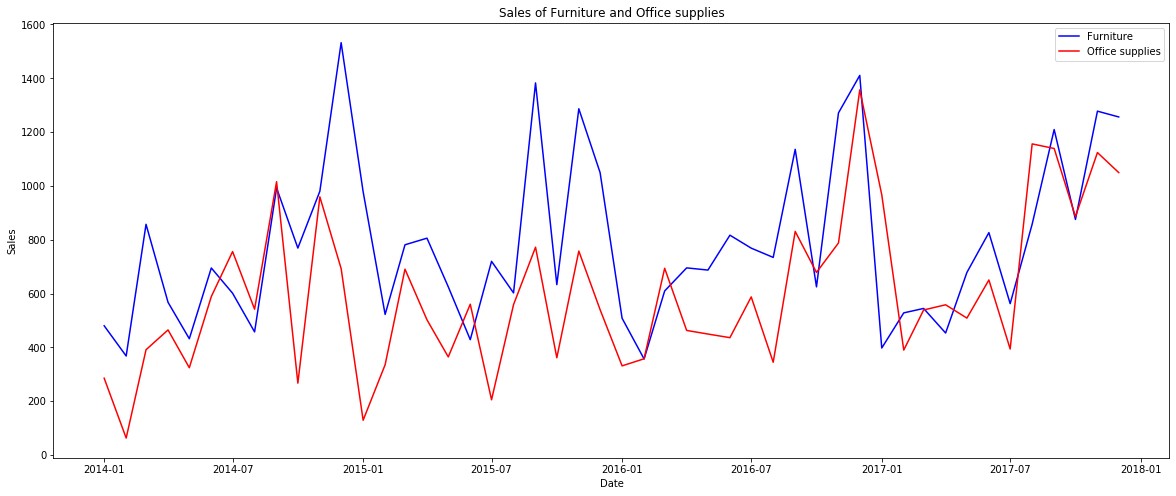

In [18]:
plt.figure(figsize=(20, 8))

plt.plot(store['Order Date'], store['furniture_sales'], 'b-', label='Furniture')
plt.plot(store['Order Date'], store['office_sales'], 'r-', label='Office supplies')
plt.legend()

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales of Furniture and Office supplies')
plt.show()

Let's see when was the first time office supplies' sales surpassed those of furniture's.

In [19]:
first_date = store.ix[np.min(list(np.where(store['office_sales'] > store['furniture_sales'])[0])), 'Order Date']

In [20]:
print('Office supplies first time produced higher sales than furniture is on {}'.format(first_date.date()))

Office supplies first time produced higher sales than furniture is on 2014-07-01


#### Time series modeling with Prophet

Fit Prophet models

In [21]:
furnitue = furniture.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
furnitue_model = Prophet(interval_width=0.95)

In [22]:
furnitue_model.fit(furnitue)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [23]:
office = office.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
office_model = Prophet(interval_width=0.95)

In [24]:
office_model.fit(office)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Make forecasts.

In [25]:
furnitue_forecast = furnitue_model.make_future_dataframe(periods=36, freq='MS')
furnitue_forecast = furnitue_model.predict(furnitue_forecast)

In [26]:
office_forecast = office_model.make_future_dataframe(periods=36, freq='MS')
office_forecast= office_model.predict(office_forecast)

Visualize forecasts.

<Figure size 1296x432 with 0 Axes>

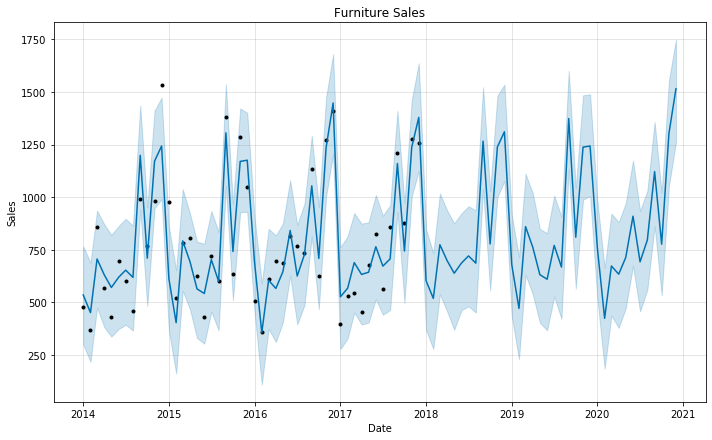

In [27]:
plt.figure(figsize=(18, 6))
furnitue_model.plot(furnitue_forecast, xlabel='Date', ylabel='Sales')
plt.title('Furniture Sales')
plt.show()

<Figure size 1296x432 with 0 Axes>

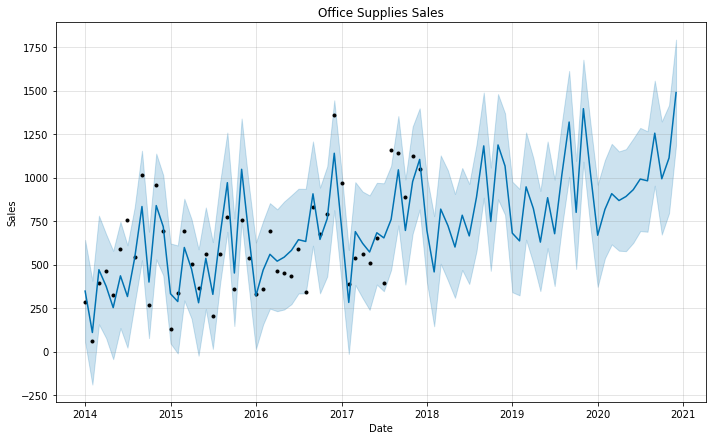

In [28]:
plt.figure(figsize=(18, 6))
office_model.plot(office_forecast, xlabel='Date', ylabel='Sales')
plt.title('Office Supplies Sales')
plt.show()

#### Compare forecasts

In [29]:
furnitue_names = ['furniture_%s' % column for column in furnitue_forecast.columns]
office_names = ['office_%s' % column for column in office_forecast.columns]

In [30]:
merge_furniture_forecast = furnitue_forecast.copy()
merge_office_forecast = office_forecast.copy()

In [31]:
merge_furniture_forecast.columns = furnitue_names
merge_office_forecast.columns = office_names

In [32]:
forecast = pd.merge(merge_furniture_forecast, merge_office_forecast, how='inner', left_on='furniture_ds', right_on='office_ds')

In [33]:
forecast = forecast.rename(columns={'furniture_ds': 'Date'}).drop('office_ds', axis=1)
forecast.head()

,Date,furniture_trend,furniture_yhat_lower,furniture_yhat_upper,furniture_trend_lower,furniture_trend_upper,furniture_additive_terms,furniture_additive_terms_lower,furniture_additive_terms_upper,furniture_yearly,...,office_additive_terms,office_additive_terms_lower,office_additive_terms_upper,office_yearly,office_yearly_lower,office_yearly_upper,office_multiplicative_terms,office_multiplicative_terms_lower,office_multiplicative_terms_upper,office_yhat
0,2014-01-01,726.057713,299.345883,766.737959,726.057713,726.057713,-190.685662,-190.685662,-190.685662,-190.685662,...,-140.040481,-140.040481,-140.040481,-140.040481,-140.040481,-140.040481,0.0,0.0,0.0,347.490278
1,2014-02-01,727.494023,217.430327,688.401093,727.494023,727.494023,-276.377703,-276.377703,-276.377703,-276.377703,...,-385.678283,-385.678283,-385.678283,-385.678283,-385.678283,-385.678283,0.0,0.0,0.0,109.240162
2,2014-03-01,728.791335,474.957962,936.330482,728.791335,728.791335,-22.389755,-22.389755,-22.389755,-22.389755,...,-31.379844,-31.379844,-31.379844,-31.379844,-31.379844,-31.379844,0.0,0.0,0.0,470.211349
3,2014-04-01,730.227645,381.548005,870.873532,730.227645,730.227645,-100.141158,-100.141158,-100.141158,-100.141158,...,-134.291690,-134.291690,-134.291690,-134.291690,-134.291690,-134.291690,0.0,0.0,0.0,374.687188
4,2014-05-01,731.617622,337.229170,820.446826,731.617622,731.617622,-160.815662,-160.815662,-160.815662,-160.815662,...,-263.821569,-263.821569,-263.821569,-263.821569,-263.821569,-263.821569,0.0,0.0,0.0,252.306682


#### Trend and forecast visualization

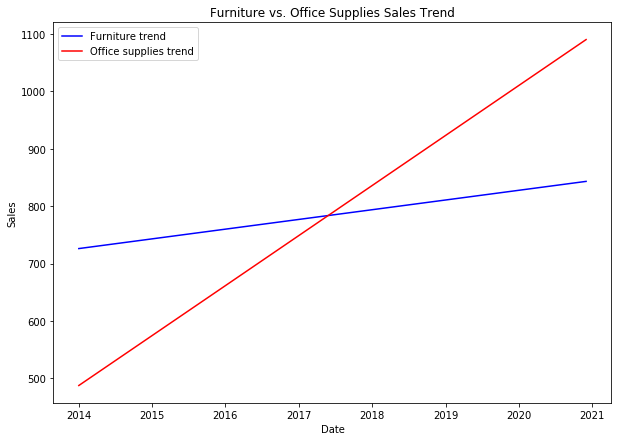

In [34]:
plt.figure(figsize=(10 ,7))

plt.plot(forecast['Date'], forecast['furniture_trend'], 'b-', label='Furniture trend')
plt.plot(forecast['Date'], forecast['office_trend'], 'r-', label='Office supplies trend')
plt.legend()

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Sales Trend')
plt.show()

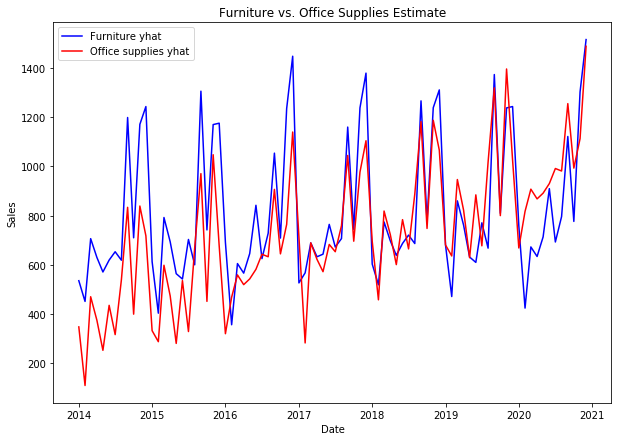

In [35]:
plt.figure(figsize=(10, 7))

plt.plot(forecast['Date'], forecast['furniture_yhat'], 'b-', label='Furniture yhat')
plt.plot(forecast['Date'], forecast['office_yhat'], 'r-', label='Office supplies yhat')
plt.legend()

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Estimate')
plt.show()

#### Trends and Patterns using Prophet models

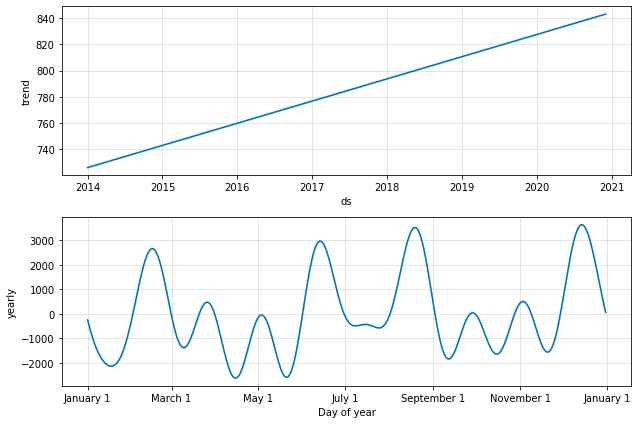

In [36]:
furnitue_model.plot_components(furnitue_forecast);

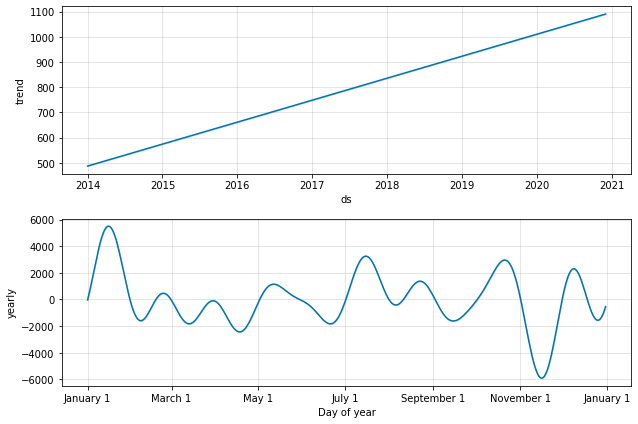

In [37]:
office_model.plot_components(office_forecast);